In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Progetto FESI'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/Progetto FESI'
/content


# Progetto
A partire da un audio contenente una semplice sequenza di note suonate con la chitarra, riconoscere le note utilizzate nell'ordine giusto ed eventualmente comporre uno spartito.

Il programma cercherà di ridurre eventuale rumore di sottofondo dall'audio passato in input.

## Librerie utilizzate:

In [ ]:
import librosa as lb
import numpy as np
from librosa import display
import matplotlib.pyplot as plt
import IPython.display as ip

In [ ]:
audio_path = "/content/drive/MyDrive/Progetto_FESI/Audio/EGBEAD.wav"
ip.Audio(audio_path)

Output hidden; open in https://colab.research.google.com to view.

### Riduzione del rumore
L'idea è quella di usare un filtro ideale (in questo caso ho scelto quello Gaussiano) dopo aver calcolato la trasformata di  Fourier e poi ricostruire il segnale "pulito" con l'inversa della trasformata di Fourier

In [ ]:
y, sr = lb.load(audio_path)

In [ ]:
freq_sound =  np.fft.fftfreq(len(y) , 1 / sr)
fourier = np.fft.fft(y)

In [ ]:
def gaussian(sigma,n):
    x = np.linspace(-n//2,n//2, n)
    bump = np.exp(-x**2/2.*sigma**2)
    bump /= np.trapz(bump) # normalize the integral to 1
    return x, bump

Text(0.5, 1.0, 'Gaussian')

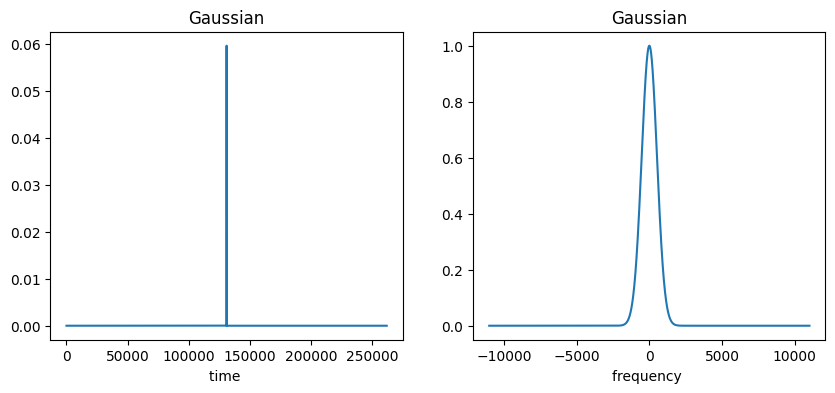

In [ ]:
x,y_gauss = gaussian(0.15, len(y))
y_shifted = np.fft.fftshift(y_gauss)
fft_gauss = np.fft.fft(y_shifted)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(y_gauss)
plt.xlabel("time ")
plt.title("Gaussian")
plt.subplot(1,2,2)
plt.plot(np.fft.ifftshift(freq_sound),np.fft.ifftshift(fft_gauss).real)
plt.xlabel("frequency ")
plt.title("Gaussian")

In [ ]:
filtered_fourier = np.multiply(fourier, fft_gauss)
filtered_sound = np.fft.ifft(filtered_fourier)

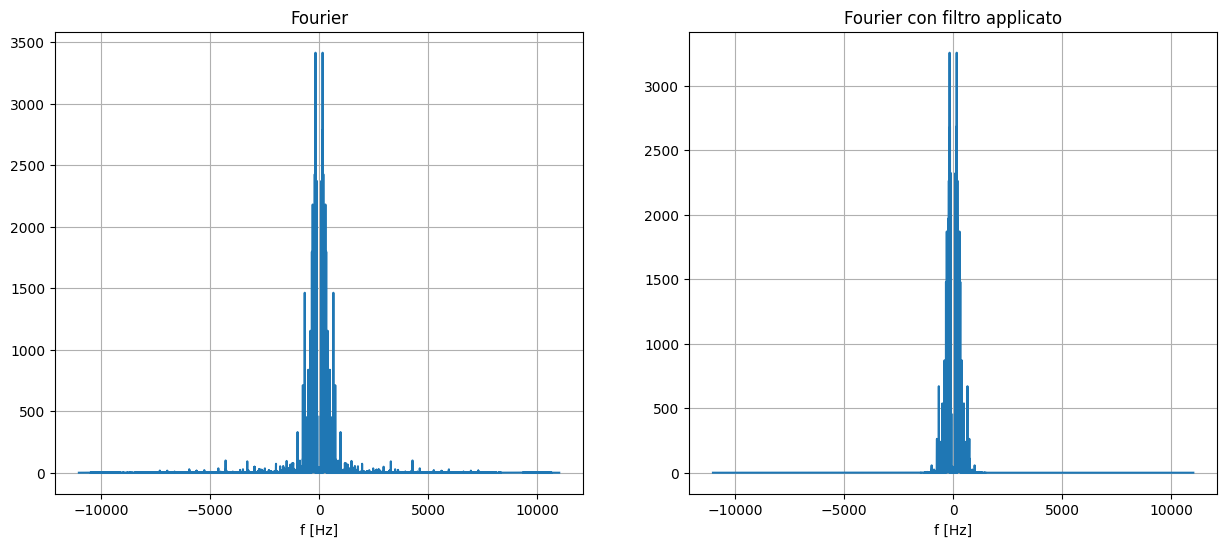

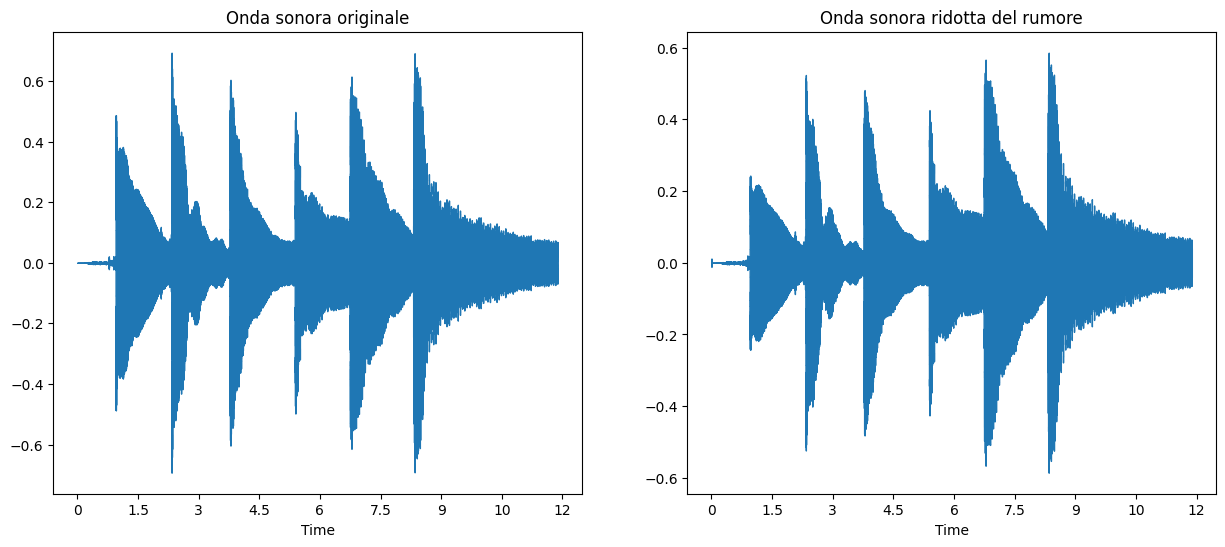

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(np.fft.ifftshift(freq_sound),np.abs(np.fft.ifftshift(fourier)))
#plt.plot(freq_sound, np.abs(fourier))
plt.xlabel('f [Hz]')
plt.title('Fourier')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.fft.ifftshift(freq_sound),np.abs(np.fft.ifftshift(filtered_fourier)))
#plt.plot(freq_sound, np.abs(filtered_fourier))
plt.xlabel('f [Hz]')
plt.title('Fourier con filtro applicato')
plt.grid()

plt.show()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
lb.display.waveshow(y, sr=sr)
plt.title('Onda sonora originale')

plt.subplot(1, 2, 2)
lb.display.waveshow(filtered_sound.real, sr=sr)
plt.title('Onda sonora ridotta del rumore')

plt.show()

In [ ]:
print("Audio originale")
ip.display(ip.Audio(y, rate=sr))
print("Audio filtrato")
ip.display(ip.Audio(filtered_sound.real, rate=sr))

Audio originale


Audio filtrato


## Scomposizione del segnale audio
Qui scomporremo il segnale audio (pulito) in segmenti e ogni segmento sarà composto da, teoricamente, una singola nota

In [ ]:
segments = []
onset_frames = lb.onset.onset_detect(y=filtered_sound.real, sr=sr)
for i in range(len(onset_frames)):
    if i == 0:
        continue

    start_frame = onset_frames[i]

    if i + 1 < len(onset_frames):
        end_frame = onset_frames[i + 1]
    else:
        end_frame = len(filtered_sound)

    start_sample = lb.frames_to_samples(start_frame)

    end_sample = lb.frames_to_samples(end_frame)

    segment = filtered_sound[start_sample:end_sample]
    segments.append(segment)

In [ ]:
plt.figure(figsize=(15, 6))
for i, segment in enumerate(segments):
    plt.subplot(1, len(segments), i + 1)
    lb.display.waveshow(segment.real, sr=sr)
    plt.title(f"Segmento {i+1}")
    plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
for i, segment in enumerate(segments):
  print(f"Audio segmento {i+1}")
  ip.display(ip.Audio(segment.real, rate=sr))

Audio segmento 1


Audio segmento 2


Audio segmento 3


Audio segmento 4


Audio segmento 5


Audio segmento 6


Audio segmento 7


Audio segmento 8


### Riconoscimento delle note
Per ogni segmento che abbiamo trovato, calcoleremo la Trasformata di Fourier e guarderemo qual è la frequenza dominante, dopodichè mapperemo questa frequenza cercheremo la nota con la frequenza più vicina.

In [ ]:
tolerance = 1 # (Hz)

In [ ]:
cutoff_freq_max = 987.77 # (Hz)
cutoff_freq_min = 65 # (Hz)

In [ ]:
def get_dominant_freq(signal):
    fft_signal = np.fft.rfft(signal)
    freq_signal =  np.fft.rfftfreq(len(signal) , 1 / sr)

    max_idx = np.argmax(np.abs(fft_signal))
    max_freq = freq_signal[max_idx]

    if max_freq > (cutoff_freq_min - tolerance) and max_freq < (cutoff_freq_max + tolerance):
      return max_freq
    else:
      return None

In [ ]:
dominants = []
for segment in segments:
  dominants.append(get_dominant_freq(segment.real))

In [ ]:
print("Frequenze dominanti: ")
for dominant  in dominants:
  print(dominant, "Hz")

Frequenze dominanti: 
319.921875 Hz
328.38134765625 Hz
227.07741477272728 Hz
247.2845262096774 Hz
196.875 Hz
163.35533405172413 Hz
217.2320197610294 Hz
145.0954461821527 Hz


In [ ]:
musical_notes = {
    "A0": 27.5,
    "A1": 55,
    "A2": 110,
    "A3": 220,
    "A4": 440,
    "A5": 880,
    "B0": 30.87,
    "B1": 61.74,
    "B2": 123.47,
    "B3": 246.94,
    "B4": 493.88,
    "B5": 987.77,
    "D0": 18.35,
    "D1": 36.71,
    "D2": 73.42,
    "D3": 146.83,
    "D4": 293.66,
    "D5": 587.33,
    "E0": 20.6,
    "E1": 41.2,
    "E2": 82.41,
    "E3": 164.81,
    "E4": 329.63,
    "E5": 659.25,
    "G0": 24.5,
    "G1": 49,
    "G2": 98,
    "G3": 196,
    "G4": 392,
    "G5": 783.99,
}

In [ ]:
def find_nearest_note(freq):
    if freq is None:
        return None

    min_diff = float('inf')
    nearest_note = None

    for note, note_freq in musical_notes.items():
        diff = abs(freq - note_freq)
        if diff < min_diff:
            min_diff = diff
            nearest_note = note

    return nearest_note

In [ ]:
def from_english_to_italian_notes(note):
  if note is None:
    return None

  if 'A' in note:
    return note.replace('A', "La")
  elif 'B' in note:
    return note.replace('B', "Si")
  elif 'D' in note:
    return note.replace('D', "Re")
  elif 'E' in note:
    return note.replace('E', "Mi")
  elif 'G' in note:
    return note.replace('G', "Sol")

In [ ]:
notes = [find_nearest_note(freq) for freq in dominants]

print(notes)

translated_notes = [from_english_to_italian_notes(note) for note in notes]

print(translated_notes)

NameError: name 'dominants' is not defined

## Costruzione dello spartito
In base alle note che abbiamo trovato costruiremo lo spartito cercando di tenere lo stesso tempo dell'audio e lo stesso ordine delle note

# Scarti

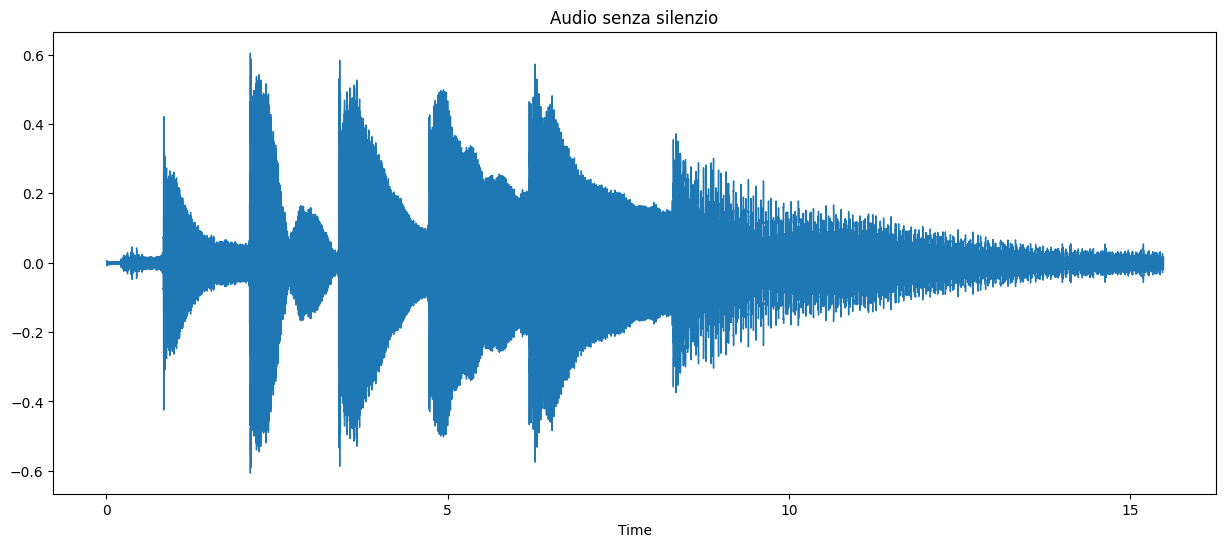

In [ ]:
segments = lb.effects.split(filtered_sound)
segments = [segment for segment in segments if (segment[1]/sr - segment[0]/sr) > 0.5]
plt.figure(figsize=(15, 6))
plt.title("Audio senza silenzio")
for i, segment in enumerate(segments):
  plt.subplot(1, len(segments), i+1)
  lb.display.waveshow(filtered_sound[segment[0]:segment[1]].real, sr=sr)
plt.show()

for segment in segments:
  ip.display(ip.Audio(filtered_sound[segment[0]:segment[1]].real, rate=sr))

In [ ]:
def recognize_notes(signal, sr):
  onset_frames = lb.onset.onset_detect(y=signal.real, sr=sr)
  onset_strength = lb.onset.onset_strength(y=signal.real, sr=sr)
  chroma = lb.feature.chroma_stft(y=signal.real, sr=sr)
  lb.display.specshow(chroma, y_axis='chroma', x_axis='time')

  #print("Onset frames \t\t Onset strenght")
  #for onset_frame in onset_frames:
  #  print(onset_frame, '\t\t', onset_strength[onset_frame])

  threshold = 1.5
  onset_frames = [onset_frame for onset_frame in onset_frames if onset_strength[onset_frame] > threshold]

  #print("Onset frames \t\t Onset strength")
  #for onset_frame in onset_frames:
  #  print(onset_frame, '\t\t', onset_strength[onset_frame])

  first = True
  notes = []
  min_note_duration = 1
  prev_note_duration = None

  for onset in onset_frames:
    chroma_at_onset = chroma[:, onset]
    note = chroma_at_onset.argmax()
    note_duration = lb.frames_to_time(onset, sr=sr)

    if not first:
      note_duration -= prev_note_duration

    if note_duration >= min_note_duration or prev_note_duration is None:
      notes.append((note, onset, note_duration))
    prev_note_duration = lb.frames_to_time(onset, sr=sr)

    first = False

  return notes

In [ ]:
chroma_to_note = {
    0: "C",
    1: "C#",
    2: "D",
    3: "D#",
    4: "E",
    5: "F",
    6: "F#",
    7: "G",
    8: "G#",
    9: "A",
    10: "A#",
    11: "B"
}

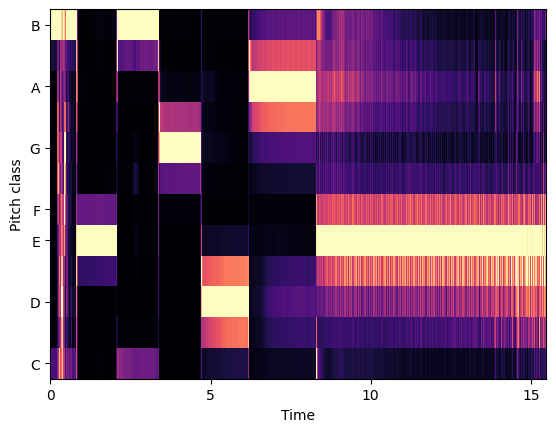

In [ ]:
notes = []
for segment in segments:
  notes.append(recognize_notes(filtered_sound[segment[0]:segment[1]], sr))

In [ ]:
print("Nota riconosciuta \t durata \t\t tempo")
for entry in notes:
  for note, time, dur in entry:
    print(chroma_to_note[note], '\t\t\t', dur, '\t', time)

Nota riconosciuta 	 durata 		 tempo
B 			 0.23219954648526078 	 10
B 			 1.2538775510204085 	 91
G# 			 1.3003174603174603 	 147
D# 			 1.3235374149659864 	 204
C 			 3.5758730158730154 	 358
